# ДЗ1 - имитационное обучение
Крайний срок сдачи - 20.02.2019 23:59.

***
Задача будет заключаться в том, чтобы провести эксперименты с имитационным обучением: смотреть, что такое клонирование поведеня и разобраться с алгоритмом DAgger.
Вместо человека-демонстранта демонстрации будут даваться специальной предобученной "экспертной" стартегией. Ваша задача будет заключаться в реализации алгоритма клонирования и DAgger, сравнения их произвоодительости на нескольких простых задачах управления из пакета OpenAI Gym. Ваше решение в виде Jupyter тетрадки *с комментариями* нужно загрузить по [ссылке](https://www.dropbox.com/request/uNq18mDY284JdI7o5KgJ) с шаблоном имени "Фамилия>\_ИАД<номер группы>.ipynb", например Панов_ИАД1.ipynb. Указывать ту группу, которую вы посещаете на семинарах.

__Будьте винимательны!__ В заготовках кода ниже могут быть неточности! Их правка входит в задачу выполнения ДЗ! Как минимум, вам нужно дописывать строчик кода ниже пометок __Ваш код здесь__.

## Требования:
### 1. __TensorFlow:__
Инструкции-напоминания по установке здесь - https://www.tensorflow.org/get_started/os_setup. GPU не будет требоваться для выполнения ДЗ.
### 2. __OpenAI Gym:__  
Напоминание-инструкции по OpenAI Gym - https://gym.openai.com/docs. Используйте версию 0.10.5.
### 3. __MuJoCo:__<br>
Будем использовать набор симуляционных сред MuJoCo.  Загружайте версию 1.50 с http://mujoco.org/,  и версию  1.50.1.56  с https://github.com/openai/mujoco-py/. Для активации доступа можно испоьзовать ваше университетский аккаунт -  https://www.roboti.us/license.html.
***

In [1]:
!pip install tensorflow
!pip3 install -U 'mujoco-py<1.50.2,>=1.50.1'
!pip install glfw3
!pip install av

    88% |████████████████████████████▎   | 65.1MB 609kB/s eta 0:00:14    57% |██████████████████▍             | 42.2MB 367kB/s eta 0:01:26    67% |█████████████████████▋          | 49.6MB 353kB/s eta 0:01:08    68% |█████████████████████▉          | 50.2MB 454kB/s eta 0:00:52    79% |█████████████████████████▋      | 58.8MB 263kB/s eta 0:00:57

Импортируем все необходимое:

In [1]:
import os
import pickle
import tensorflow as tf
print("TensorFlow version :",tf.__version__)

import numpy as np
import tf_util
import gym
print("Gym version :",gym.__version__)

import glfw
import load_policy

TensorFlow version : 1.12.0
Gym version : 0.10.9


***
## Собираем статистику

 Генерируем статистику (roll-outs) по заданной экспертной стратегии в 3 шага:
 1. Загружаем стратегию из файла и инициализируем окружение.
 2. Начинаем сессию tensorflow.
 3. В рамках сессии собираем данные: до конца эпизода в цикле выбираем экспертное действие, применяем его и сохраняем результаты.

In [2]:
#choose environment (Uncomment choosed one)
# env_name="Humanoid-v2"
# env_name="Ant-v2"
# env_name="HalfCheetah-v2"
# env_name="Hopper-v2"
# env_name="Reacher-v2"
env_name="Walker2d-v2"

# choose expert policy file from /expert file
expert_policy_file="experts/"+env_name+".pkl"

# load the policy
print('loading and building expert policy')
policy_fn = load_policy.load_policy(expert_policy_file)
print('loaded and built')

# make the environment
env = gym.make(env_name)

# function to generate rollouts from the expert policies 
def generate_rollouts(num_rollouts,max_steps,render=False):
    
    # initialize tensoflow session (tf stuff)
    with tf.Session():
        tf_util.initialize()

        # collect rollouts
        # firstly, define the arrays
        returns = []
        observations = []
        actions = []

        # loop to collect data
        for i in range(num_rollouts):
            #number of iteration (episode)
            #print('iter', i)
            # parameters to initial values
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            # loop until the end of the episode
            while not done:
                # choose an action depending on the observation
                action = policy_fn(obs[None,:])
                # append sample to arrays
                observations.append(obs)
                actions.append(action)
                # apply the action on the environment
                obs, r, done, _ = env.step(action)
                # calculate the total reward
                totalr += r
                steps += 1
                # render the environment
                if render==True:
                    env.render()
                #if steps % 100 == 0: print("%i/%i"%(steps, max_steps))
                if steps >= max_steps:
                    break
            # append the total reward
            returns.append(totalr)
        env.close()
        
        # print the reward information
        #print('returns', returns)
        print('mean return', np.mean(returns))
        print('std of return', np.std(returns))

        expert_data = {'observations': np.array(observations),'actions': np.array(actions)}
            
        return expert_data

loading and building expert policy
obs (1, 17) (1, 17)
loaded and built


Тестируем реализованную функцию: num_rollouts=4,max_steps=100,render=True

Notes:
- If the camera doesn't track the agent, prss __Tab__ to change the viewpoint
- In some cases the jupyter notebok kernel will crash if you close the rendering window, __don't close the windows until finishing the execution of the whole notebook.__

In [3]:
generate_rollouts(num_rollouts=4,max_steps=100,render=False);

Instructions for updating:
Please use tf.global_variables instead.
Instructions for updating:
Use `tf.variables_initializer` instead.
mean return 222.34014287296804
std of return 1.2084148843760845


In [4]:
# env.env.close()
# try:
#     del env
#     print('deleted')
# except ImportError:
#     print

***
## 1. Клонирование поведения

Клонирование поведения (Behavioural cloning, BC) - метод, с помощью когорого компьютерная программа обучается воспроизводить действия эксперта (человека). Действия эксперта записываются, а затем эта статистика используется как входные данные для алгоритма обучения. Этот алгоритм в результате формирует последовательность действий, по которым воспроизводится поведение эксперта.

Будем использовать стандартное обучение с учителем и использовать нейронную сеть для этого.

Кроме конструктора, вам нужно дореализовать метод __train__ класса __BC_Model__:

In [5]:
from sklearn.utils import shuffle

class BC_Model(object):
    def __init__(self, input_data, output_data, batch_size = 64):
        
        # define tensorflow session
        self.sess = tf.Session()
        # input and output data , and their shapes
        self.batch_size = batch_size
        self.input_data = input_data
        self.output_data = np.reshape(output_data, (output_data.shape[0], output_data.shape[2]))
        self.input_shape = [self.batch_size, self.input_data.shape[-1]]
        self.output_shape = [self.batch_size, self.output_data.shape[-1]]
        
        # placeholders for the neural network (input, model output and the expert output)
        self.input_placeholder = tf.placeholder(tf.float32, shape = self.input_shape)
        self.output_placeholder_expert = tf.placeholder(tf.float32, shape = self.output_shape)
        self.output_placeholder_model = self.build_model(self.input_placeholder)
        
        # the loss function Mean squared error, (L2 stands for Least Square Errors)
        ### Ваш код здесь - нужно добавить функцию потерь l2_loss ###
        
        self.loss = tf.nn.l2_loss(self.output_placeholder_model-self.output_placeholder_expert)
        

    def build_model(self, input_placeholder):
        # build the neural network  (you can try another architecture)
        ### Ваш код здесь - нужно реализовать свою архитектуру ###
        x = tf.layers.Dense(200)(input_placeholder)
        x = tf.layers.Dense(150, activation=tf.nn.sigmoid)(x)
        x = tf.layers.Dense(100)(x)
        x = tf.layers.Dense(self.output_data.shape[1])(x)
        
        return x

    def train(self, epochs = 50, train_data = None, test_data = None):
        # check train and test data
        if train_data is None and test_data is None :
            # split the input data to train and test if test and train data are not given
            train_data, test_data = shuffle(self.input_data, self.output_data, random_state = 0)
        else:
            #reshape test data
            test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2]))
        
        # using Adam optimizer
        optimizer = tf.train.AdamOptimizer().minimize(self.loss)
        # define a saver
        saver = tf.train.Saver()
        
        # number of batches
        batch_idxs = len(train_data) // self.batch_size

        # define a writer ()
        writer = tf.summary.FileWriter("exp")
        
        # add the graph (The model and all the variables) to the writer
        writer.add_graph(self.sess.graph)

        #initialize network variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        #loop over epochs
        for epoch in range(epochs):
            #for each epoch loop over batches
            for idx in range(batch_idxs):
                # take a batch from training and test data
                batch_train = train_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                batch_value = test_data[idx * self.batch_size : (idx + 1) * self.batch_size]
                # run the optimizer to reduce the loss (we train the model to give us the same output for specific input)
                feed_train = {self.input_placeholder : batch_train, self.output_placeholder_expert : batch_value}
                self.sess.run(optimizer, feed_dict = feed_train)
                    
        # save the model
        saver.save(self.sess, "exp" + "/behavior_cloning_model")

    def sample(self, input):
        #sample an action for a specified input
        output = self.sess.run(self.output_placeholder_model, feed_dict = {self.input_placeholder : np.repeat(input[None, :], self.batch_size, axis = 0)})
        return output[0]

### Обучем модель на экспертных данных

In [6]:
# generate expert data
data=generate_rollouts(num_rollouts=20,max_steps=100,render=False);
x = data['observations']
y = data['actions']
print ('dimension of obs :', x.shape)
print('dimension of actions :', y.shape)

# shuffle data
x,y = shuffle(x,y)

# create an object from BC_Model class, and train it
cloner=BC_Model(x,y)
cloner.train()

mean return 221.68345206715293
std of return 1.3643746709500577
dimension of obs : (2000, 17)
dimension of actions : (2000, 1, 6)


### Испытываем модель

In [7]:

num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
#         env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

mean return 214.84626891951103
std of return 57.0332280978024


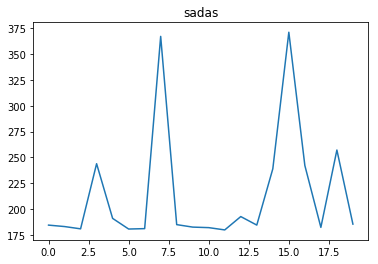

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("sadas")
plt.plot(range(num_eval_rollouts), returns)
plt.show()

__Задание 1.1.__ Вам необходимо обучить модель на любых трех окружениях MoJoCo. Построить графики отдачи (totalr) в зависимости от количества набранной статистики (num_rollouts) для обучения.

In [10]:
# env_name="Humanoid-v2"
# env_name="Ant-v2"
# env_name="HalfCheetah-v2"
# env_name="Hopper-v2"
# env_name="Reacher-v2"
# env_name="Walker2d-v2"

n_rollouts = 500
test_n_rollouts = 10
rewards = {}

for env_name in ["Humanoid-v2", "Ant-v2", "Reacher-v2"]:
    expert_policy_file="experts/"+env_name+".pkl"
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('loaded and built', expert_policy_file)

    rewards[env_name] = []
    env = gym.make(env_name)
    for n_rolls in np.geomspace(1, n_rollouts, 10):
        print("n_rollouts: ", int(n_rolls))
        data = generate_rollouts(num_rollouts=int(n_rolls),max_steps=150,render=False)
        x = data['observations']
        y = data['actions']
        x,y = shuffle(x,y)

        cloner=BC_Model(x,y)
        cloner.train()
        
        returns=[]
        for i in range(test_n_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
#                 env.render()
                totalr+=r
            returns.append(totalr)
        rewards[env_name].append(np.mean(returns))
#     plt.title(env_name)
#     plt.plot
        
# For env in [env1,env2,env3]:
# ... Load env 
# ... For n in num rollouts: 
# ....... Generate data(n)
# ....... Build model 
# ....... Train model 
# ... Plt. plot 

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built experts/Humanoid-v2.pkl
n_rollouts:  1
mean return 1085.4505645304287
std of return 0.0
n_rollouts:  1
mean return 1109.6031641158247
std of return 0.0
n_rollouts:  3
mean return 1103.151614277388
std of return 2.720161097904956
n_rollouts:  7
mean return 1104.4885983767472
std of return 13.178342958887653
n_rollouts:  15
mean return 1097.812097629595
std of return 23.16369710113356
n_rollouts:  31
mean return 1111.0274205924275
std of return 17.274408651111678
n_rollouts:  62
mean return 1111.43263964236
std of return 15.64352190762819
n_rollouts:  125
mean return 1112.6920267120943
std of return 14.951837873575505
n_rollouts:  250
mean return 1113.2204893747128
std of return 16.251891032936506
n_rollouts:  499
mean return 1111.0233923442645
std of return 31.021324908553716
loading and building expert policy
obs (1, 111) (1, 111)
loaded and built experts/Ant-v2.pkl
n_rollouts:  1
mean return 602.6368502434453
st

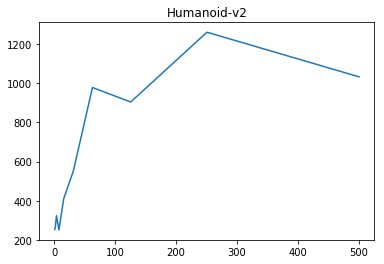

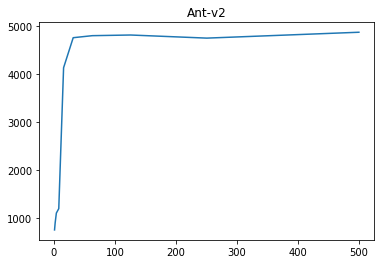

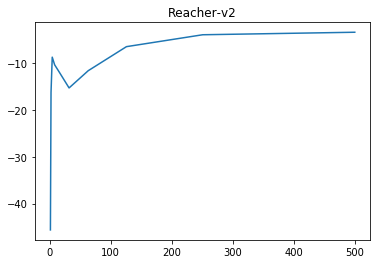

In [12]:
for env_name in rewards.keys():
    plt.title(env_name)
    plt.plot(np.geomspace(1, n_rollouts, 10), rewards[env_name])
    plt.show()

__Задание 1.2.__ Выберите один из гиперапараметров вашей модели, которые влияют на качество обучения (количество эпох, количество слоев и т.п.). Для одного из окружений постройте график влияния значения этого параметра на качество обучения (totalr).

In [17]:
test_n_rollouts = 10

for env_name in ["Humanoid-v2"]:
    expert_policy_file="experts/"+env_name+".pkl"
    print('loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('loaded and built', expert_policy_file)

    rewards = []
    env = gym.make(env_name)
    n_rolls = 30
    for n_epochs in np.linspace(1, 100, 8):
        print("n_epochs: ", int(n_epochs))
        data = generate_rollouts(num_rollouts=int(n_rolls),max_steps=150,render=False)
        x = data['observations']
        y = data['actions']
        x,y = shuffle(x,y)

        cloner=BC_Model(x,y)
        cloner.train(epochs=int(n_epochs))
        
        returns=[]
        for i in range(test_n_rollouts):
            totalr=0
            done=False
            obs=env.reset()
            while not done:
                action=cloner.sample(obs)
                obs,r,done,_=env.step(action)
#                 env.render()
                totalr+=r
            returns.append(totalr)
        rewards.append(np.mean(returns))

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built experts/Humanoid-v2.pkl
n_epochs:  1
mean return 1112.505926599606
std of return 13.50375645896482
n_epochs:  15
mean return 1110.808186441071
std of return 16.353468091191438
n_epochs:  29
mean return 1110.3138708031772
std of return 13.652946924798036
n_epochs:  43
mean return 1110.4480315470353
std of return 18.444821740625272
n_epochs:  57
mean return 1115.0116671512296
std of return 18.806843619020583
n_epochs:  71
mean return 1111.4896092945194
std of return 19.95487449904722
n_epochs:  85
mean return 1110.4202456713317
std of return 14.082955257521979
n_epochs:  100
mean return 1114.2759995104086
std of return 16.413415329752056


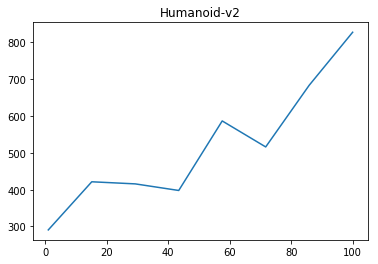

In [20]:
plt.title("Humanoid-v2")
plt.plot(np.linspace(1, 100, 8), rewards)
plt.show()

***
## 2. DAgger Algorithm

Цель алгоритма DAgger (data Aggregation) - собрать статистику обучаемой модели, вместо экспертных данных. 
- Вначале мы тренируем BC_Model на собранных экспертных данных.
- Запускаем модель на окружениие, собираем наблюдения.
- Затем мы просим эксперта (человека) отметить, какие действия нужно совершать в полученных наблюдениях (по сути используем __policy_fn__).
- Создаем новую коллекцию помеченных и экспертных данных.
- Потворяем.

![image.png](attachment:image.png)

In [19]:
from tqdm import tqdm

with tf.Session():
    DAgger_iter=10
    render=False
    # DAgger loop
    for i in tqdm(range(DAgger_iter)):
        # reset in each iteration
        new_obs = []
        new_actions = []
        obs = env.reset()
        done = False
        # collect data from model and expert
        while not done:
            # get an action from the model
            ### Ваш код здесь - испольузуем оубченную модель ###
            action = cloner.sample(obs)
            
            obs, _, done, _ = env.step(action)
            if render:
                env.render()
            # get the expert action for the same input
            ### Ваш код здесь - испольузуем olicy_fn!! ###
            corrected_action = policy_fn(obs[None,:])
            
            # append the observation and expert action to the data set
            new_obs.append(obs)
            new_actions.append(corrected_action)
        # re-order the data
        x = np.concatenate((x, obs[None, :]), axis = 0)
        y = np.concatenate((y, corrected_action[None, :]), axis = 0)
        # train the model on the collected data
        ### Ваш код здесь - дообучаем модель ###
        cloner.train(300, x, y)
        

100%|██████████| 10/10 [05:02<00:00, 30.75s/it]


### Проверяем работу

In [21]:
num_eval_rollouts=20
# loop over runouts
returns=[]
for i in range(num_eval_rollouts):
    # reset variables in each iteration
    totalr=0
    done=False
    obs=env.reset()
    # loop until the end of the episode
    while not done:
        # get an action from the trained model (output for specific observation as input)
        action=cloner.sample(obs)
        # implement the action
        obs,r,done,_=env.step(action)
#         env.render()
        totalr+=r
    returns.append(totalr)
print('mean return', np.mean(returns))
print('std of return', np.std(returns))

Creating window glfw
mean return 835.5018221970622
std of return 289.2393521349761


__Задание 2.1.__ Проверьте работу DAagger на всех задачах MoJoCo - укажите для какой задачи он работает лучше, чем простое клонирование. Покажите это на графиках.

In [23]:
env_names=["Humanoid-v2", "Ant-v2", "HalfCheetah-v2", "Hopper-v2", "Reacher-v2", "Walker2d-v2"]

n_rollouts = 30
test_n_rollouts = 5
DAgger_iter=4
rewards = {}

for env_name in env_names:
    expert_policy_file="experts/"+env_name+".pkl"
#     print('loading and building expert policy')
    policy_fn = load_policy.load_policy(expert_policy_file)
    print('loaded and built', expert_policy_file)
    
    rewards[env_name]={}
    rewards[env_name]['clone']=[]
    rewards[env_name]['dagger']=[]
    
    env = gym.make(env_name)
    n_rolls = 100
    data = generate_rollouts(num_rollouts=int(n_rolls),max_steps=150,render=False)
    x = data['observations']
    y = data['actions']
    x,y = shuffle(x,y)

    cloner=BC_Model(x,y)
    cloner.train()

    ### test:
    print('test clone')
    returns=[]
    for i in range(test_n_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            totalr+=r
        returns.append(totalr)
    rewards[env_name]['clone'].append(np.mean(returns))

    print('train dagger')
    with tf.Session():
        render=False
        # DAgger loop
        for i in tqdm(range(DAgger_iter)):
            # reset in each iteration
            new_obs = []
            new_actions = []
            obs = env.reset()
            done = False
            # collect data from model and expert
            while not done:
                # get an action from the model
                ### Ваш код здесь - испольузуем оубченную модель ###
                action = cloner.sample(obs)

                obs, _, done, _ = env.step(action)
                if render:
                    env.render()
                # get the expert action for the same input
                ### Ваш код здесь - испольузуем olicy_fn!! ###
                corrected_action = policy_fn(obs[None,:])

                # append the observation and expert action to the data set
                new_obs.append(obs)
                new_actions.append(corrected_action)
            # re-order the data
            x = np.concatenate((x, obs[None, :]), axis = 0)
            y = np.concatenate((y, corrected_action[None, :]), axis = 0)
            # train the model on the collected data
            ### Ваш код здесь - дообучаем модель ###
            cloner.train(300, x, y)
    print('test dagger')
    returns=[]
    for i in range(test_n_rollouts):
        totalr=0
        done=False
        obs=env.reset()
        while not done:
            action=cloner.sample(obs)
            obs,r,done,_=env.step(action)
            totalr+=r
        returns.append(totalr)
    rewards[env_name]['dagger'].append(np.mean(returns))

obs (1, 376) (1, 376)
loaded and built experts/Humanoid-v2.pkl
mean return 1104.5461772551075
std of return 77.28406574343451
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [05:58<00:00, 89.47s/it]

test dagger
obs (1, 111) (1, 111)
loaded and built experts/Ant-v2.pkl
mean return 660.5904152242958
std of return 40.39759460557622
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [05:04<00:00, 76.10s/it]

test dagger
obs (1, 17) (1, 17)
loaded and built experts/HalfCheetah-v2.pkl
mean return 501.7236809910366
std of return 27.212839888294013
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [04:28<00:00, 67.12s/it]

test dagger
obs (1, 11) (1, 11)
loaded and built experts/Hopper-v2.pkl
mean return 394.91050048302435
std of return 1.3324727903064268
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [04:35<00:00, 69.15s/it]

test dagger
obs (1, 11) (1, 11)
loaded and built experts/Reacher-v2.pkl
mean return -3.8401800141113913
std of return 1.559124550847766
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [02:16<00:00, 34.17s/it]

test dagger
obs (1, 17) (1, 17)
loaded and built experts/Walker2d-v2.pkl
mean return 431.85913525345285
std of return 4.510293323265983
test clone



  0%|          | 0/4 [00:00<?, ?it/s]

train dagger



100%|██████████| 4/4 [04:53<00:00, 73.45s/it]

test dagger


Text(0, 0.5, 'reward')

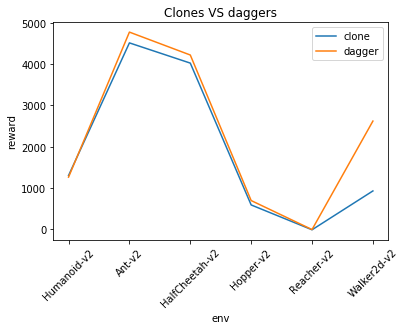

In [32]:
clones = []
daggers = []
for env_name in env_names:
    clones.append(rewards[env_name]['clone'][0])
    daggers.append(rewards[env_name]['dagger'][0])

plt.title("Clones VS daggers")
plt.plot(range(len(env_names)), clones, label='clone')
plt.plot(range(len(env_names)), daggers, label='dagger')
plt.legend()
plt.xlabel("env")
plt.xticks(range(6), tuple(env_names), rotation=45)
plt.ylabel("reward")
# rewards

## Вывод
Только для окружения Humanoid-v2 в данных условиях склонированная модель работает лучше, чем дообученная при помощи dataAggregation. Во всех остальных случаях алгоритм с DAgger работает лучше, что особенно заметно на окружении Walker2d-v2

#### Прошу прощения за задержку, совсем не хватает времени в течении этой недели, буду премного благодарен, если засчитаете сданным в день дедлайна, а не после :)